Label
BENIGN              1014454
DoS Hulk             172846
DDoS                 128014
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Heartbleed               11
Name: count, dtype: int64


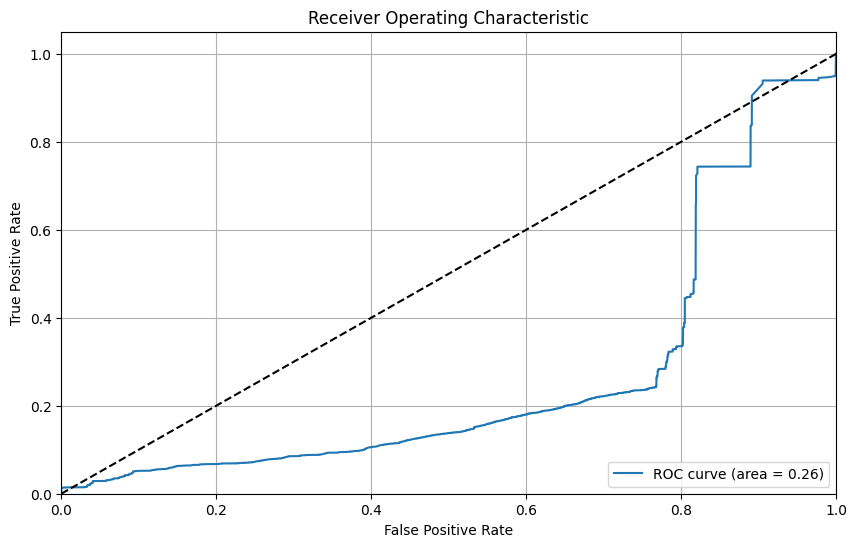

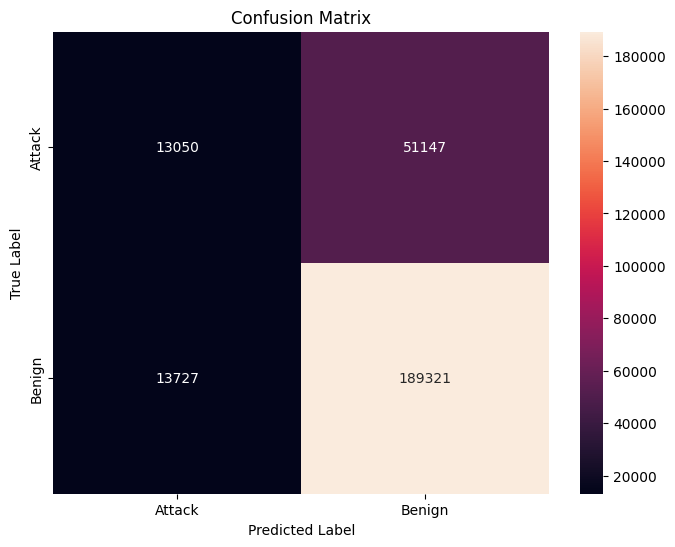

              precision    recall  f1-score   support

      Attack       0.49      0.20      0.29     64197
      Benign       0.79      0.93      0.85    203048

    accuracy                           0.76    267245
   macro avg       0.64      0.57      0.57    267245
weighted avg       0.72      0.76      0.72    267245



In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_parquet('IDS2017/Final/Combined.parquet')

# Display the value counts of the labels
print(data['Label'].value_counts())

# Prepare the labels
y = data['Label']
y = y.apply(lambda x: 0 if x != 'BENIGN' else 1)  # 1 - benign, 0 - attack

# Prepare the features
X = data.drop('Label', axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # 80% training and 20% test

# Train the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, random_state=42)
iso_forest.fit(X_train)

# Calculate anomaly scores on the test set
y_score = -iso_forest.decision_function(X_test)

# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Predict the labels
y_pred = iso_forest.predict(X_test)
y_pred = np.where(y_pred == -1, 0, 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with labels and a color bar
labels = ['Attack', 'Benign']  # Define your labels here
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=labels))
